### Общая информация
В этом проекте будем работать с данными об условиях жизни учащихся в возрасте от 15 до 22 лет и их успеваемостью по математике.
Необходимо по имеющемуся датасету провести разведывательный анализ данных и отобрать признаки, оказывающие влияние на оценку по математике, для модели, предсказывающей результаты госэкзамена для каждого ученика школы и еще на ранней стадии помогающей выявить студентов, находящихся в группе риска не сдачи итогового экзамена.     
Давайте попробуем!

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline
warnings.simplefilter('ignore')

sns.set(style="darkgrid")
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [2]:
stud_math = pd.read_csv('stud_math.xls')

### 1. Первичный осмотр данных

Итак, начнем с того, что посмотрим какие данные хранятся в файле и какие типы данных у столбцов:

In [3]:
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [4]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В датасете содержится информация о 395 учениках. Все столбцы, кроме первых 3-х (shool, sex, age) имеют в значениях пропуски. Данные представлены в 30 столбцах, из них 17 столбцов имеют строковый тип, остальные 13 - числовой тип.   

Однако в числовые столбцы попали категориальные переменные, у которых значения закодированы числовым диапазоном.    

Поэтому по факту у нас есть только 3 количественных переменных: age (непрерывная количиственная), absences и score (дискретные количественные переменные), при этом score - целевая переменная.    

Остальные 27 переменных являются категориальными, из них 10 (Medu; Fedu; traveltime; studytime; failures; studytime,granular; famrel; freetime; goout; health) - качественные порядковые переменные;    
и 17 (school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic) - качественные номинативные переменные

Посмотрим есть ли у нас неинформативные признаки, у которых более 95% строк содержат одно и тоже значение.

In [5]:
num_rows = len(stud_math.index)
low_information_cols = []

for col in stud_math.columns:
    cnts = stud_math[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    if top_pct > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {top_pct*100 :.5%}')
        print(cnts)
        print()
print(f'Неинформативные признаки отсутствуют')

Неинформативные признаки отсутствуют


 А есть ли дубликаты строк?

In [6]:
if stud_math.duplicated().sum() == 0:
    print(f'Дубликаты строк отсутствуют')
else:
    print(f'Есть дубликаты строк')

Дубликаты строк отсутствуют


In [7]:
# отбор числовых колонок
stud_numeric = stud_math.select_dtypes(include=[np.number])
numeric_col = stud_numeric.columns.values

# отбор нечисловых колонок - категориальных номинальных переменных
stud_non_numeric = stud_math.select_dtypes(exclude=[np.number])
non_numeric_col = stud_non_numeric.columns.values

# отбор числовых переменных
stud_num = ['age', 'absences', 'score']

# отбор категориальных порядковых переменных
stud_kat_num = [x for x in numeric_col if x not in stud_num]

### 2. Анализ данных в столбцах

***- по количественным переменным:***

In [8]:
stud_math[stud_num].describe()

,age,absences,score
count,395.000000,383.000000,389.000000
mean,16.696203,7.279373,52.262211
std,1.276043,23.465197,22.919022
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,40.000000
50%,17.000000,4.000000,55.000000
75%,18.000000,8.000000,70.000000
max,22.000000,385.000000,100.000000


Предварительно по основным статистическим характеристикам видим, что есть пропущенные значения, а также:
1. данные по количеству пропущенных занятий (absences) и по баллам по госэкзамену (score) сильно рассеяны относительно своего среднего, т.к. имеют большое значение стандартного отклонения
2. в данных по количеству пропущенных занятий (absences) скорее всего будут обнаружены выбросы, т.к. значение max=385, а медиана=4

Давайте посмотрим на распределение признаков, наличие выбросов и пропусков в данных

In [9]:
def an_intcol(col, value=None):
    print(f'Признак: \033[1m\033[30m{col}')
    print(f'mode     {stud_math[col].mode().loc[0]}')
    display(stud_math[col].describe())
    
    # Построим график распределения признака
    fig, ax = plt.subplots()
    stud_math[col].hist(ax=ax)
    plt.show()

    pct_missing = stud_math[col].isna().mean()  # определение процента выбросов
    print(f'Признак {col} имеет {pct_missing :.2%} пропусков')

    # Проверка на наличие выбросов по межквартильному размаху
    # и выбранным диапозонам данных в датасете
    IQR = stud_math[col].quantile(0.75) - stud_math[col].quantile(0.25)
    l = stud_math[col].quantile(0.25) - 1.5*IQR
    r = stud_math[col].quantile(0.75) + 1.5*IQR

    if stud_math[stud_math[col].between(l, r)].shape[0] > 0 and value == None:
        print(f'Признак {col} имеет выбросы:')
        display(stud_math[(stud_math[col] < l) | (stud_math[col] > r)])
    elif value != None and stud_math[~((stud_math[col].between(
            value[0], value[1])) | (pd.isna(stud_math[col])))].shape[0] > 0:
        print(f'Признак {col} имеет выбросы:')
        display(stud_math[~((stud_math[col].between(
            value[0], value[1])) | (pd.isna(stud_math[col])))])
    else:
        print(f'У признака {col} выбросов нет')
    print()
    print()

Признак: age
mode     16


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

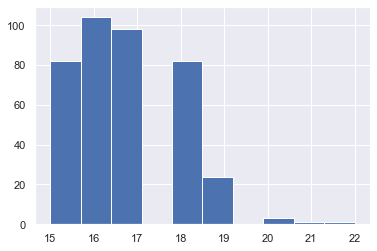

Признак age имеет 0.00% пропусков
Признак age имеет выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,-3.0,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0




Признак: absences
mode     0.0


count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

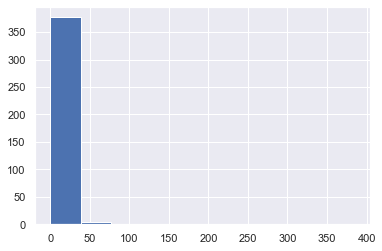

Признак absences имеет 3.04% пропусков
Признак absences имеет выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0




Признак: score
mode     50.0


count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

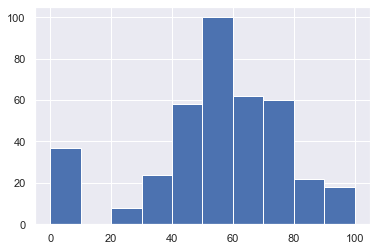

Признак score имеет 1.52% пропусков
У признака score выбросов нет




In [10]:
an_intcol('age')
an_intcol('absences')
an_intcol('score', value=(0, 100))

### age

У данного признака нет пропущенных значений, наибольшее количество данных расположено в возрастном диапазоне от 15 до 17 лет включительно. При помощи метода межквартильного размаха обнаружен 1 выброс со значением 22 года, однако мы его не будем считать за выброс, т.к. он по условиям проекта входит в рассматриваемый диапазон возрастных значений.     
Давайте из этого количественного признака сделаем порядковый категориальный с диапазоном возрастов: 1 - от 15 до 17 лет, 2 - от 18 до 19 лет, 3 - остальные возраста

In [11]:
stud_math['age_kat'] = stud_math['age'].apply(lambda x: 1 if 15 <= x <= 17 else 2 if 18 <= x <= 19 else 3)

### absences

Посмотрим на эти данные повнимательней

<AxesSubplot:>

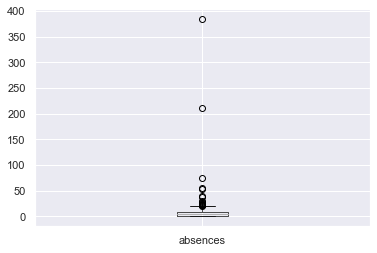

In [12]:
stud_math.boxplot(column=['absences'], figsize=(6, 4))

Уберем самые большие значения выбросов: 212 и 385. И опять посмотрим на распределение данных

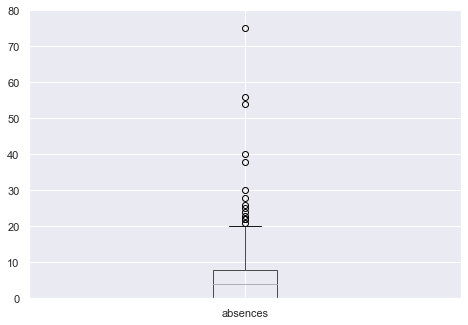

In [13]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
# устанавливаем границы осей (устраняет некоторые выбросы)
axes.set_ylim(0, 80)
stud_math.boxplot(column=['absences'])

Выбросы не превышающие значения 30 возможно могут быть допустимыми, так как занятий в учебном году должно быть больше этой цифры

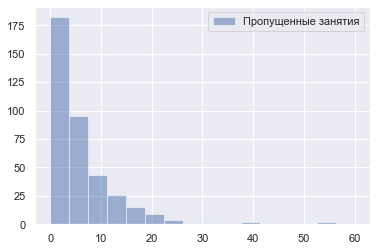

In [14]:
stud_math['absences'].hist(alpha=0.5, bins=16,
                           range=(0, 60), label='Пропущенные занятия')
plt.legend()

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0]


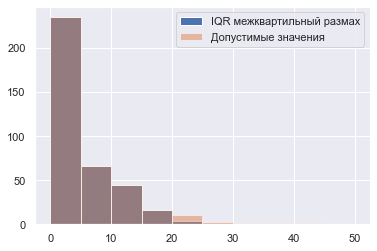

In [15]:
perc25 = stud_math['absences'].quantile(0.25)
perc75 = stud_math['absences'].quantile(0.75)
IQR = perc75 - perc25
print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR},\
 Границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}]')
stud_math['absences'].loc[stud_math['absences'].between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10,\
                                              range=(0, 50),\
                                              label='IQR межквартильный размах')
stud_math['absences'].loc[stud_math['absences'] <= 60].hist(
    alpha=0.5, bins=10, range=(0, 50), label='Допустимые значения')
plt.legend()

Видим, что основное распределение лежит между 0 и 20 и есть выбросы больше 20. Имеются 2 выброса с критическими значениями: 212 и 385. Хотя выбросом по межквартильному размаху в этих данных являются значения больше 20, видим что также допустимыми для анализа значениями могут быть и данные, которые не превышают значения 30. Поэтому для устранения выбросов возьмем данные по этому признаку в пределах от нижней границы межквартильного размаха до 30. 

In [16]:
stud_math.loc[~(stud_math['absences'].between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR) |
    pd.isna(stud_math['absences'])), 'absences'].sort_values()

260     21.0
313     22.0
277     22.0
216     22.0
320     23.0
198     24.0
40      25.0
103     26.0
205     28.0
280     30.0
307     38.0
315     40.0
74      54.0
183     56.0
276     75.0
390    212.0
222    385.0
Name: absences, dtype: float64

In [17]:
stud_math = stud_math.loc[stud_math['absences'].between(
    perc25 - 1.5*IQR, 30) | pd.isna(stud_math['absences'])]

Посмотрим на эти данные после преобразования:

<AxesSubplot:>

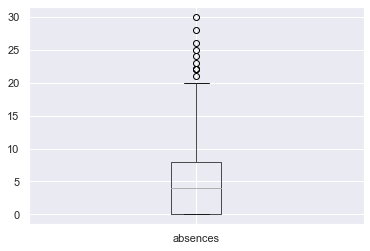

In [18]:
stud_math.boxplot(column=['absences'], figsize=(6, 4))

### score

У целевой переменной небольшое количество пропусков. Хотя выбросов значений нет, однако достаточно много учеников с нулевым баллом по госэкзамену по математике. Не сдавали экзамен или набрали совсем мало баллов и не сдали? Оставим данные без изменения, учитывая, что балл по условиям проекта может находится в диапазоне от 0 до 100.

***- по порядковым категориальным переменным:***

In [19]:
stud_kat_num.append('age_kat') # добавили новую категориальную переменную

In [20]:
stud_math[stud_kat_num].describe()

,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,age_kat
count,385.000000,364.000000,360.000000,381.00000,366.000000,381.00000,362.000000,378.000000,380.000000,373.000000,388.000000
mean,2.750649,2.609890,1.441667,2.03937,0.333333,-6.11811,3.936464,3.240741,3.115789,3.530831,1.286082
std,1.104044,2.248112,0.697738,0.84668,0.742697,2.54004,0.925985,0.984081,1.112303,1.397863,0.474804
min,0.000000,0.000000,1.000000,1.00000,0.000000,-12.00000,-1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,1.00000,0.000000,-6.00000,4.000000,3.000000,2.000000,3.000000,1.000000
50%,3.000000,2.000000,1.000000,2.00000,0.000000,-6.00000,4.000000,3.000000,3.000000,4.000000,1.000000
75%,4.000000,3.000000,2.000000,2.00000,0.000000,-3.00000,5.000000,4.000000,4.000000,5.000000,2.000000
max,4.000000,40.000000,4.000000,4.00000,3.000000,-3.00000,5.000000,5.000000,5.000000,5.000000,3.000000


Предварительно по основным статистическим характеристикам видим, что есть пропущенные значения, а также:
1. в данных в столбцах Fedu, famrel вероятно есть ошибки в сборе данных, т.к. присутствуют значения, несоответствующие выбранной классификации для этих данных. Для Fedu - это значение 40, для famrel - это значение -1 


Давайте посмотрим на распределение признаков, наличие выбросов и пропусков в данных

In [21]:
def an_pkatcol(col, value=None):
    print(f'Признак: \033[1m\033[30m{col}')
    print(f'mode     {stud_math[col].mode().loc[0]}')
    display(stud_math[col].describe())
    
    # Построим график распределения признака
    fig, axes = plt.subplots(ncols=3)
    sns.countplot(stud_math[col], ax=axes[0])
    axes[0].set_title('График распределения признака')
    sns.barplot(x=col, y='score', data=stud_math, ax=axes[1])
    axes[1].set_title('Влияние признака на оценку')
    sns.boxplot(x=col, y='score', data=stud_math, ax=axes[2])
    axes[2].set_title('Влияние признака на оценку')
    fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
    plt.show()

    pct_missing = stud_math[col].isna().mean()  # определение процента выбросов
    print(f'Признак {col} имеет {pct_missing :.2%} пропусков')

    # Проверка на наличие выбросов 
    IQR = stud_math[col].quantile(0.75) - stud_math[col].quantile(0.25)
    l = stud_math[col].quantile(0.25) - 1.5*IQR
    r = stud_math[col].quantile(0.75) + 1.5*IQR
    
    if stud_math[stud_math[col].between(l, r)].shape[0] > 0 and value == None:
        print(f'Признак {col} имеет выбросы:')
        display(stud_math[(stud_math[col] < l) | (stud_math[col] > r)])
    elif value != None and stud_math[~((stud_math[col].between(
            value[0], value[1])) | (pd.isna(stud_math[col])))].shape[0] > 0:
        print(f'Признак {col} имеет выбросы:')
        display(stud_math[~((stud_math[col].between(
            value[0], value[1])) | (pd.isna(stud_math[col])))])
    else:
        print(f'У признака {col} выбросов нет')
        
    # Сколько уникальных значений содержится в признаке?
    print(f'У признака {stud_math[col].nunique()} уникальных значений:')
    print(f'{stud_math[col].unique()}')
    
    print()
    print()

Признак: Medu
mode     4.0


count    385.000000
mean       2.750649
std        1.104044
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

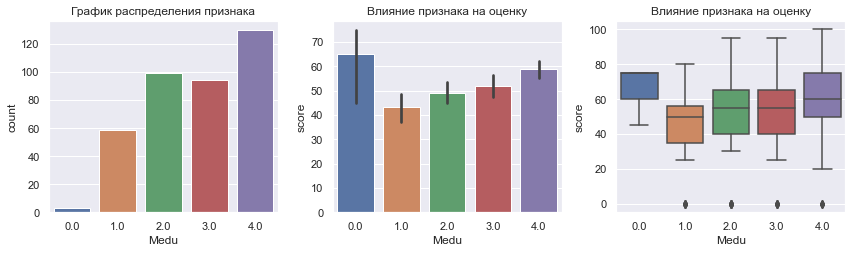

Признак Medu имеет 0.77% пропусков
У признака Medu выбросов нет
У признака 5 уникальных значений:
[ 4.  1.  3.  2. nan  0.]


Признак: Fedu
mode     2.0


count    364.000000
mean       2.609890
std        2.248112
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

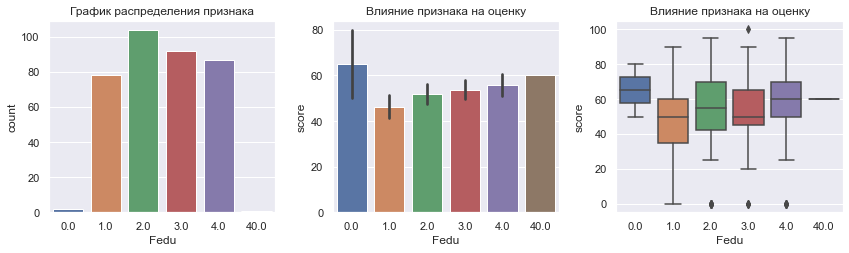

Признак Fedu имеет 6.19% пропусков
Признак Fedu имеет выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score,age_kat
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0,1


У признака 6 уникальных значений:
[ 4.  1.  2.  3. 40. nan  0.]


Признак: traveltime
mode     1.0


count    360.000000
mean       1.441667
std        0.697738
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

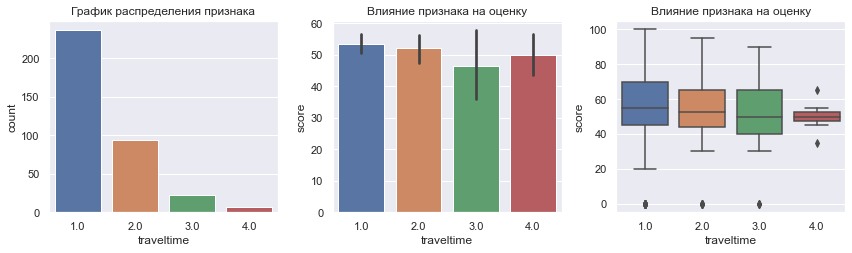

Признак traveltime имеет 7.22% пропусков
У признака traveltime выбросов нет
У признака 4 уникальных значений:
[ 2.  1.  3. nan  4.]


Признак: studytime
mode     2.0


count    381.00000
mean       2.03937
std        0.84668
min        1.00000
25%        1.00000
50%        2.00000
75%        2.00000
max        4.00000
Name: studytime, dtype: float64

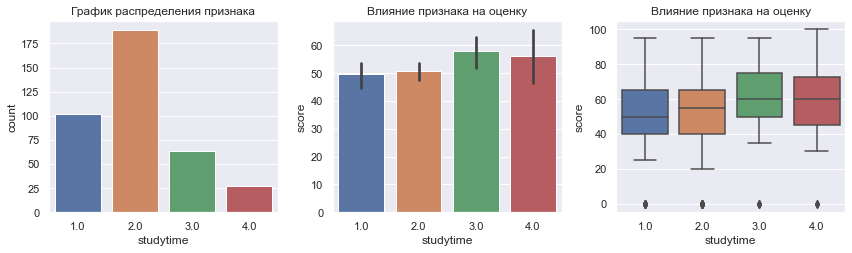

Признак studytime имеет 1.80% пропусков
У признака studytime выбросов нет
У признака 4 уникальных значений:
[ 2.  3.  1. nan  4.]


Признак: failures
mode     0.0


count    366.000000
mean       0.333333
std        0.742697
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

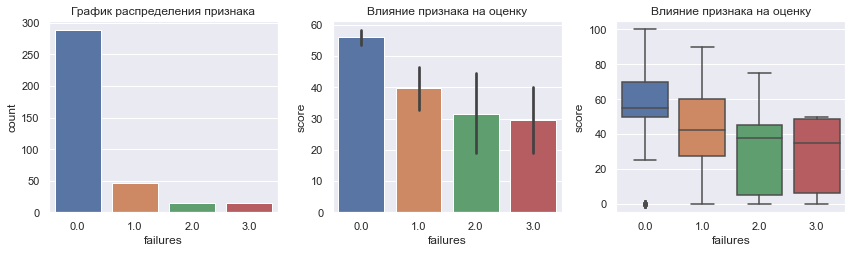

Признак failures имеет 5.67% пропусков
У признака failures выбросов нет
У признака 4 уникальных значений:
[ 0.  3. nan  2.  1.]


Признак: studytime, granular
mode     -6.0


count    381.00000
mean      -6.11811
std        2.54004
min      -12.00000
25%       -6.00000
50%       -6.00000
75%       -3.00000
max       -3.00000
Name: studytime, granular, dtype: float64

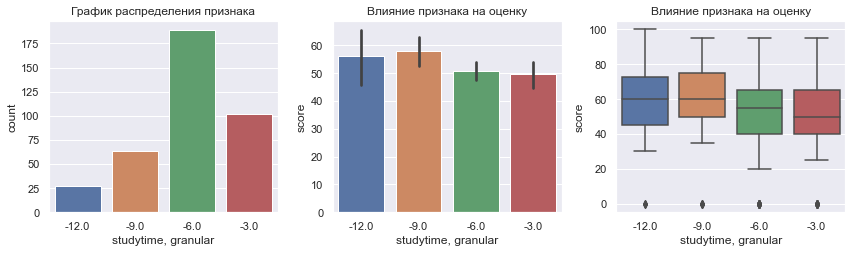

Признак studytime, granular имеет 1.80% пропусков
У признака studytime, granular выбросов нет
У признака 4 уникальных значений:
[ -6.  -9.  -3.  nan -12.]


Признак: famrel
mode     4.0


count    362.000000
mean       3.936464
std        0.925985
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

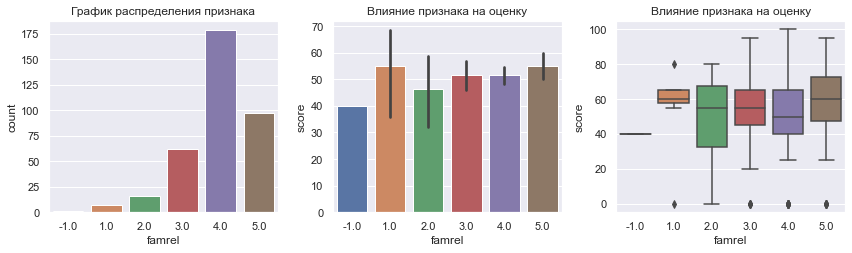

Признак famrel имеет 6.70% пропусков
Признак famrel имеет выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score,age_kat
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0,1


У признака 6 уникальных значений:
[ 4.  5.  3. nan -1.  2.  1.]


Признак: freetime
mode     3.0


count    378.000000
mean       3.240741
std        0.984081
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

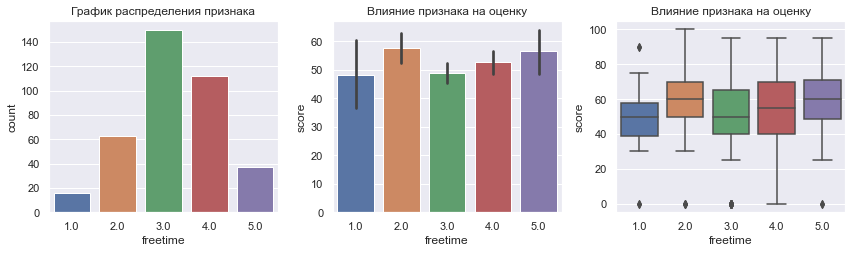

Признак freetime имеет 2.58% пропусков
У признака freetime выбросов нет
У признака 5 уникальных значений:
[ 3.  2.  4.  1.  5. nan]


Признак: goout
mode     3.0


count    380.000000
mean       3.115789
std        1.112303
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

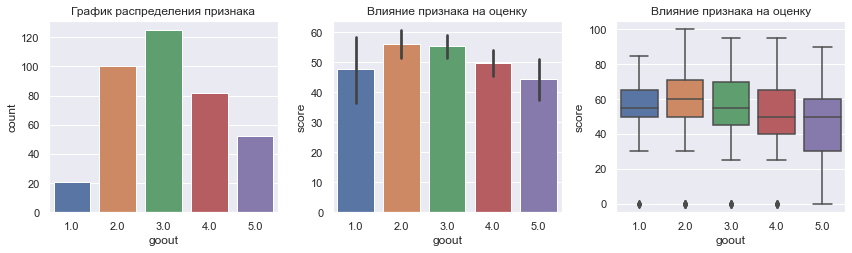

Признак goout имеет 2.06% пропусков
У признака goout выбросов нет
У признака 5 уникальных значений:
[ 4.  3.  2.  1.  5. nan]


Признак: health
mode     5.0


count    373.000000
mean       3.530831
std        1.397863
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

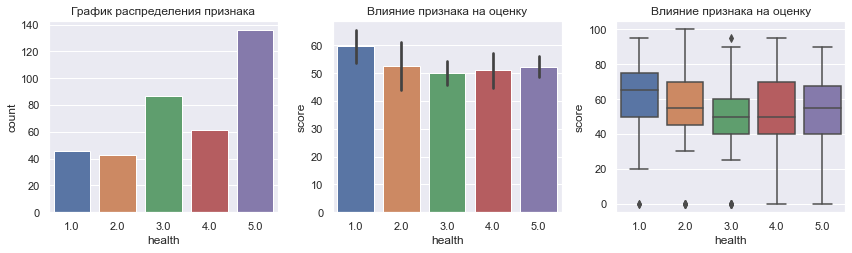

Признак health имеет 3.87% пропусков
У признака health выбросов нет
У признака 5 уникальных значений:
[ 3.  5.  1.  2.  4. nan]


Признак: age_kat
mode     1


count    388.000000
mean       1.286082
std        0.474804
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: age_kat, dtype: float64

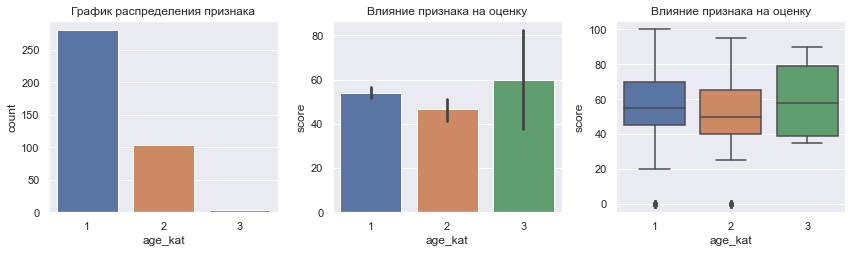

Признак age_kat имеет 0.00% пропусков
У признака age_kat выбросов нет
У признака 3 уникальных значений:
[2 1 3]




In [22]:
an_pkatcol('Medu', value=(0, 4))
an_pkatcol('Fedu', value=(0, 4))
an_pkatcol('traveltime', value=(0, 4))
an_pkatcol('studytime', value=(0, 4))
an_pkatcol('failures', value=(0, 3))
an_pkatcol('studytime, granular', value=(-12, -3))
an_pkatcol('famrel', value=(1, 5))
an_pkatcol('freetime', value=(1, 5))
an_pkatcol('goout', value=(1, 5))
an_pkatcol('health', value=(1, 5))
an_pkatcol('age_kat', value=(1,3))

По графикам что все признаки в той или иной степени оказывают влияние на оценку по математике, при этом обнаружены любопытные вещи:
- отсутствие образования у матери и отца приводит к высоким оценкам у учеников, при этом повышение роста образования родителей плавно отражается на росте оценок. Распределение этих признаков в образовании родителей одинаковы, поэтому можно их объединить в один
- если предположить, что под цифрой 0 в признаке количества внеучебных неудач закодировано отсутствие этих неудач или наоборот их очень большое количество (все силы брошены на изучение математики), то это приводит только к высоким оценкам по математике
- интересно, что чем хуже здоровье ученика, тем выше у него оценка. Все остальные состояния здоровья примерно одинаково влияют на оценку. Поэтому можем эти данные разбить на 2 диапозона: плохое здоровье, нормальное здоровье.
- ученики младших возрастных категорий имеют в целом средние оценки, становясь старше успеваемость падает (наверное другим интересуются) и уже в самой старшей категории оценка увеличивается по сравнению с другими возрастными группами (наверное берутся за ум или сильно долго учились и наконец-то выучились)

В целом данные достаточно чистые, т.к. процент пропуска в значениях не превышает 7.22%, замечены небольшие выбросы в столбцах age, Fedu, famrel. Давайте рассмотрим подробнее эти данные.

### Fedu

У данного признака есть 24 пропущенных значения и один выброс, который не соответствует выбранной для него классификации значений в диапозоне от 0 до 4. Можем предположить, что этот выброс вызван ошибкой при вводе данных. Этот выброс можем удалить или преобразовать его в значение 4, преобразуем в значение 4.

In [23]:
stud_math['Fedu'][11] = 4

### famrel

У признака есть один выброс и пропуски. Выброс не соотвествует условиям проекта по своему значению, поэтому удалим его. 

In [24]:
stud_math = stud_math.loc[stud_math['famrel'].between(
    1, 5) | pd.isna(stud_math['famrel'])]

***- по номинальным категориальным переменным:***

In [25]:
stud_math.describe(include=['object'])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,387,387,370,360,345,368,351,370,357,378,350,347,373,371,367,353,356
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,342,202,289,255,311,129,195,136,245,329,214,196,193,294,349,298,236


Предварительно по основным характеристикам видим, что в нашем датасете преимущественно больше учеников:
- женского пола
- проживающих в городе
- в семьях, в которых членов семьи больше 3-х и опекуном является мать
- у которых оба родителя работают в сферах, отличных от отдельно выделенных в данном датасете
- причиной выбора школы является образовательная программа в этой школе
- не имеющих дополнительной образовательной поддержки и платных занятий по математике, и не находящихся в романтических отношениях
- но имеющие семейную образовательную поддержку, дополнительные внеучебные занятия, желание получить высшее образование и наличие интернета дома

Давайте посмотрим на распределение признаков, наличие выбросов и пропусков в данных

In [26]:
def an_nkatcol(col, value=None):
    print(f'Признак: \033[1m\033[30m{col}')
    print()
    print(f'mode     {stud_math[col].mode().loc[0]}')
    display(stud_math[col].describe())
    
    # Построим график распределения признака
    fig, axes = plt.subplots(ncols=3)
    sns.countplot(stud_math[col], ax=axes[0])
    axes[0].set_title('График распределения признака')
    sns.barplot(x=col, y='score', data=stud_math, ax=axes[1])
    axes[1].set_title('Влияние признака на оценку')
    sns.boxplot(x=col, y='score', data=stud_math, ax=axes[2])
    axes[2].set_title('Влияние признака на оценку')
    fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
    plt.show()

    pct_missing = stud_math[col].isna().mean()  # определение процента выбросов
    print(f'Признак {col} имеет {pct_missing :.2%} пропусков')

    # Сколько уникальных значений содержится в признаке?
    print(f'У признака {stud_math[col].nunique()} уникальных значений:')
    print(f'{stud_math[col].unique()}')
    print()
    print()

Признак: school

mode     GP


count     387
unique      2
top        GP
freq      342
Name: school, dtype: object

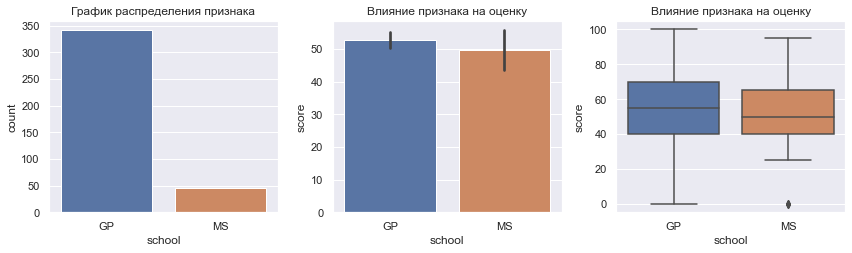

Признак school имеет 0.00% пропусков
У признака 2 уникальных значений:
['GP' 'MS']


Признак: sex

mode     F


count     387
unique      2
top         F
freq      202
Name: sex, dtype: object

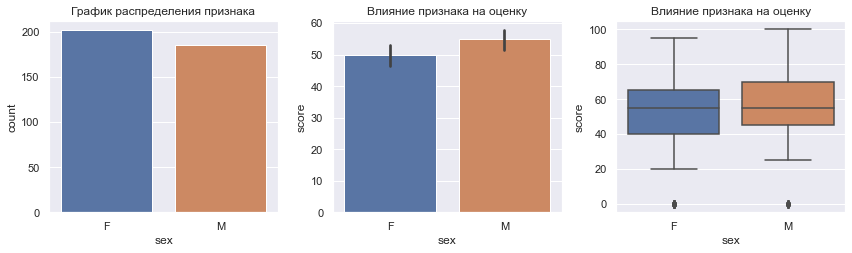

Признак sex имеет 0.00% пропусков
У признака 2 уникальных значений:
['F' 'M']


Признак: address

mode     U


count     370
unique      2
top         U
freq      289
Name: address, dtype: object

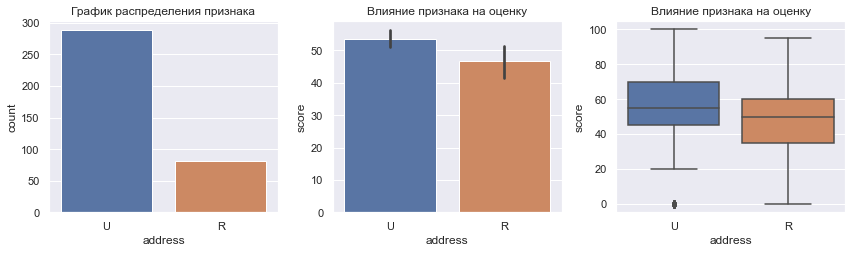

Признак address имеет 4.39% пропусков
У признака 2 уникальных значений:
['U' nan 'R']


Признак: famsize

mode     GT3


count     360
unique      2
top       GT3
freq      255
Name: famsize, dtype: object

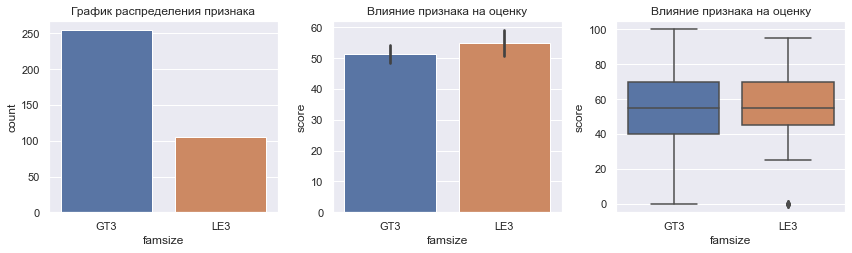

Признак famsize имеет 6.98% пропусков
У признака 2 уникальных значений:
[nan 'GT3' 'LE3']


Признак: Pstatus

mode     T


count     345
unique      2
top         T
freq      311
Name: Pstatus, dtype: object

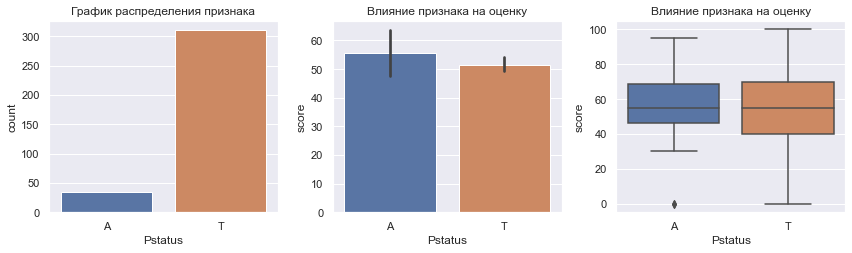

Признак Pstatus имеет 10.85% пропусков
У признака 2 уникальных значений:
['A' nan 'T']


Признак: Mjob

mode     other


count       368
unique        5
top       other
freq        129
Name: Mjob, dtype: object

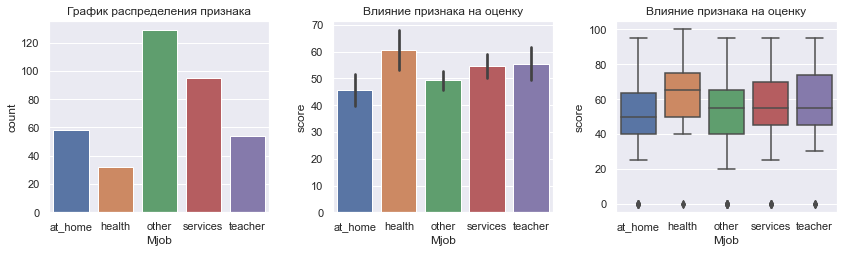

Признак Mjob имеет 4.91% пропусков
У признака 5 уникальных значений:
['at_home' 'health' 'other' 'services' 'teacher' nan]


Признак: Fjob

mode     other


count       351
unique        5
top       other
freq        195
Name: Fjob, dtype: object

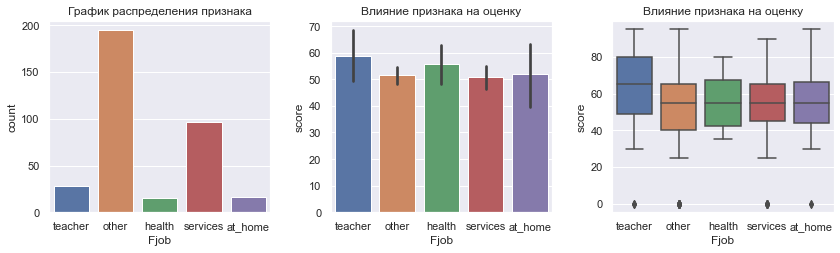

Признак Fjob имеет 9.30% пропусков
У признака 5 уникальных значений:
['teacher' 'other' nan 'health' 'services' 'at_home']


Признак: reason

mode     course


count        370
unique         4
top       course
freq         136
Name: reason, dtype: object

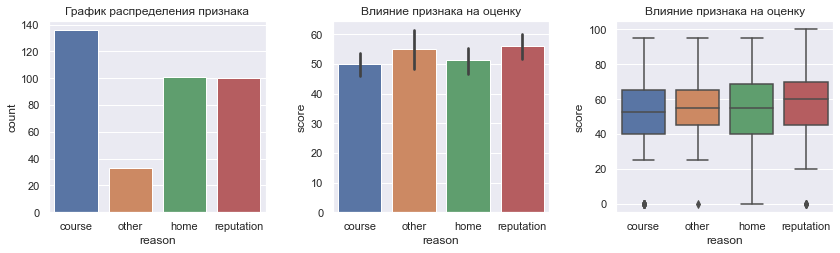

Признак reason имеет 4.39% пропусков
У признака 4 уникальных значений:
['course' 'other' 'home' 'reputation' nan]


Признак: guardian

mode     mother


count        357
unique         3
top       mother
freq         245
Name: guardian, dtype: object

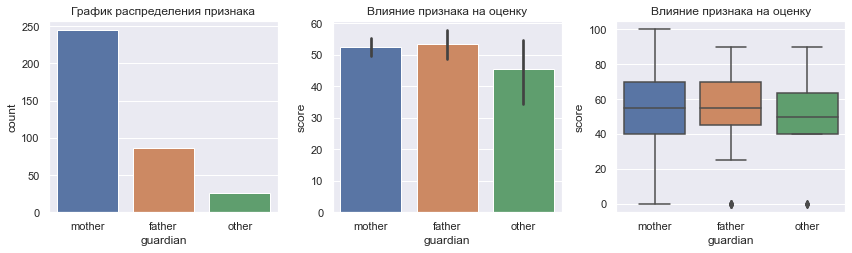

Признак guardian имеет 7.75% пропусков
У признака 3 уникальных значений:
['mother' 'father' 'other' nan]


Признак: schoolsup

mode     no


count     378
unique      2
top        no
freq      329
Name: schoolsup, dtype: object

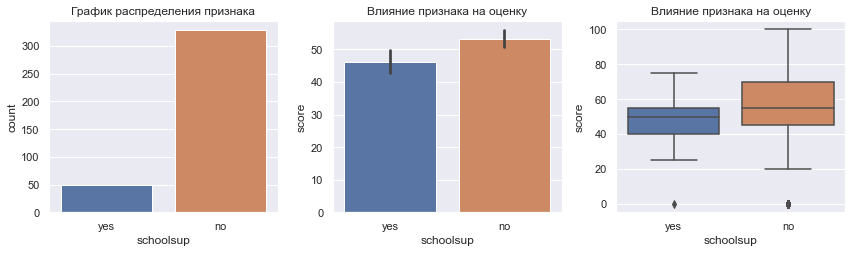

Признак schoolsup имеет 2.33% пропусков
У признака 2 уникальных значений:
['yes' 'no' nan]


Признак: famsup

mode     yes


count     350
unique      2
top       yes
freq      214
Name: famsup, dtype: object

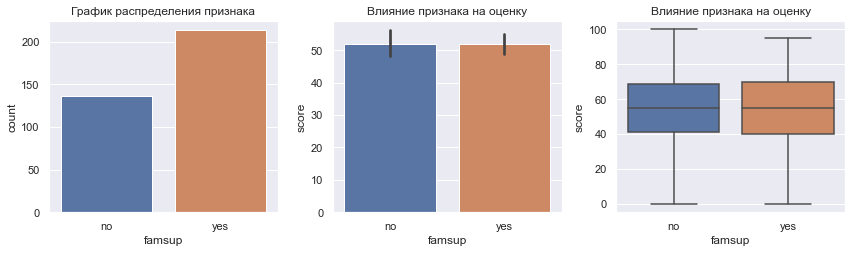

Признак famsup имеет 9.56% пропусков
У признака 2 уникальных значений:
['no' 'yes' nan]


Признак: paid

mode     no


count     347
unique      2
top        no
freq      196
Name: paid, dtype: object

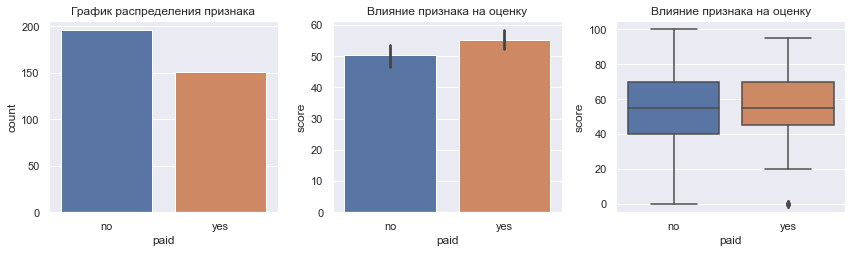

Признак paid имеет 10.34% пропусков
У признака 2 уникальных значений:
['no' nan 'yes']


Признак: activities

mode     yes


count     373
unique      2
top       yes
freq      193
Name: activities, dtype: object

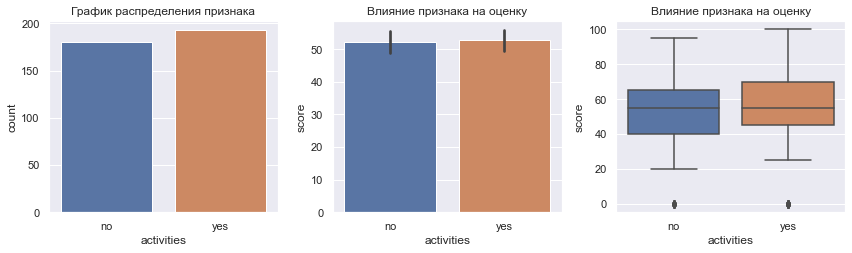

Признак activities имеет 3.62% пропусков
У признака 2 уникальных значений:
['no' 'yes' nan]


Признак: nursery

mode     yes


count     371
unique      2
top       yes
freq      294
Name: nursery, dtype: object

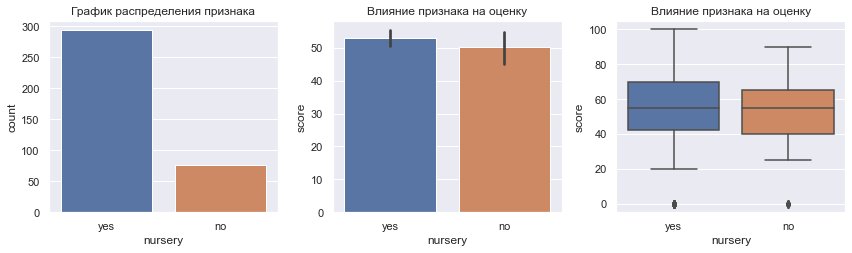

Признак nursery имеет 4.13% пропусков
У признака 2 уникальных значений:
['yes' 'no' nan]


Признак: higher

mode     yes


count     367
unique      2
top       yes
freq      349
Name: higher, dtype: object

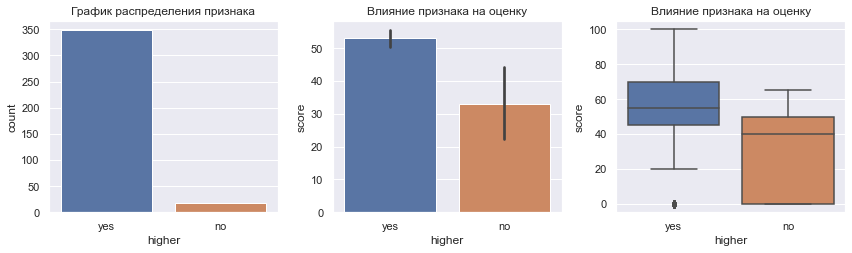

Признак higher имеет 5.17% пропусков
У признака 2 уникальных значений:
['yes' nan 'no']


Признак: internet

mode     yes


count     353
unique      2
top       yes
freq      298
Name: internet, dtype: object

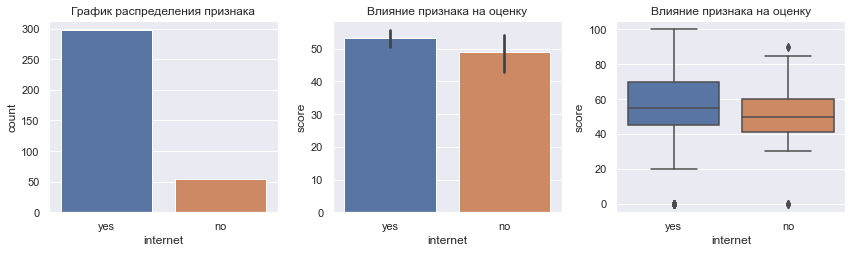

Признак internet имеет 8.79% пропусков
У признака 2 уникальных значений:
[nan 'yes' 'no']


Признак: romantic

mode     no


count     356
unique      2
top        no
freq      236
Name: romantic, dtype: object

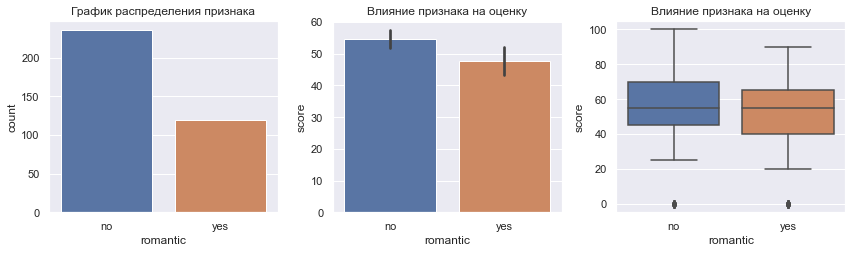

Признак romantic имеет 8.01% пропусков
У признака 2 уникальных значений:
['no' nan 'yes']




In [27]:
an_nkatcol('school')
an_nkatcol('sex')
an_nkatcol('address')
an_nkatcol('famsize')
an_nkatcol('Pstatus')
an_nkatcol('Mjob')
an_nkatcol('Fjob')
an_nkatcol('reason')
an_nkatcol('guardian')
an_nkatcol('schoolsup')
an_nkatcol('famsup')
an_nkatcol('paid')
an_nkatcol('activities')
an_nkatcol('nursery')
an_nkatcol('higher')
an_nkatcol('internet')
an_nkatcol('romantic')

Только 2 категорийных признака не имеют пропусков. Это: school и sex. У остальных процент пропусков колеблется от 2.33% до 10.85%. Высокий уровень пропусков имеют признаки Pstatus 10.85%, Fjob 9,3%, famsup 9.56%, paid 10.34% и internet 8.79%.   
По признаку Fjob работа отца видно, что все виды работ отца существенно не влияют на оценку ученика по математике, за исключением случаев, когда отец работает учителем.    
По графикам видно, что все признаки так или иначе влияют на оценку по математике, кроме признака famsup семейной образовательной поддержки (это странно).

### 3. Анализ номинативных переменных

С помощью теста Стьюдента проверим есть ли статистическая разница в распределении оценок по категориальным признакам, проверив нулевую гипотезу о том, что распределение оценок по госэкзамену по различным параметрам неразличимы

In [28]:
# посчитаем статистику
def get_nomvar(column):
    cols = stud_math.loc[:, col].dropna().unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'].dropna(),
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score'].dropna()).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

Посчитаем статистику для порядковых категориальных признаков:

In [29]:
for col in stud_kat_num:
    get_nomvar(col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки age_kat


Посчитаем статистику для номинальных категориальных признаков:

In [30]:
for col in non_numeric_col:
    get_nomvar(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Итак серьезно различаются 7 номинативных признаков с процентом пропусков в значениях: sex 0.0%, address 4.39%, Mjob 4.91%, shoolsup 2.33%, paid 10.34%, higher 5.17%, romantic 8.01%. Но выше из графиков видно, что и другие признаки оказывают влияние, кроме признака famsup, поэтому этот признак удалим. Признаки school, famsize, activites, nursery не оказывают сильного влияния на оценку, поэтому их тоже удалим, а остальные признаки оставим для модели. Интересно как на оценку по математике влияют романтические отношения?

In [31]:
stud_math.drop(['famsup', 'school', 'famsize', 'activities', 'nursery'], axis=1, inplace=True)

### 4. Корреляционный анализ

Выясним какие столбцы коррелируют с оценкой на госэкзамене по математике. Это поможет понять какие признаки стоит оставить для модели, а какие нужно будет исключить из анализа

***- по количественным переменным:***

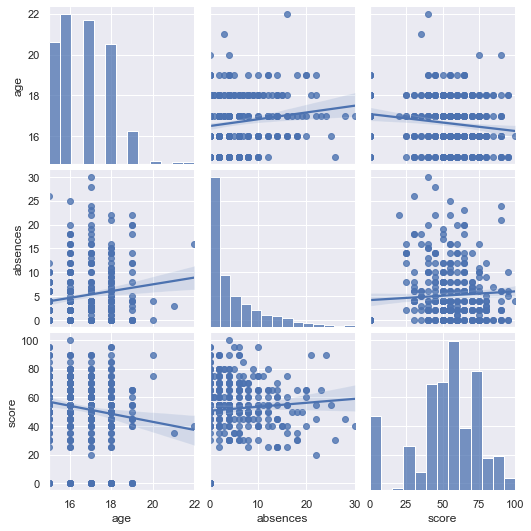

In [32]:
sns.pairplot(stud_math[stud_num], kind='reg')

In [33]:
correlation = stud_math[stud_num].corr()
correlation

,age,absences,score
age,1.000000,0.153600,-0.152729
absences,0.153600,1.000000,0.071273
score,-0.152729,0.071273,1.000000


<AxesSubplot:>

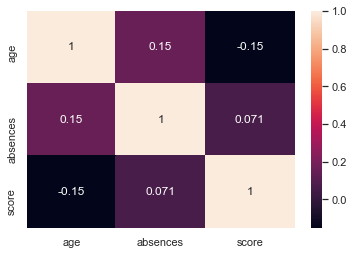

In [34]:
sns.heatmap(correlation, annot = True)

Признак (absences ) количество пропущенных занятий мало влияет на оценку по математике, поэтому удалим этот признак.

In [35]:
stud_math.drop('absences', axis=1, inplace=True)

***- по порядковым категорийным переменным:***

In [36]:
stud_kat_num.append('score')
correlation_ = stud_math[stud_kat_num].corr()
correlation_

,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,age_kat,score
Medu,1.000000,0.626486,-0.182362,0.082797,-0.243701,-0.082797,-0.023969,0.024558,0.058486,-0.045677,-0.088454,0.218427
Fedu,0.626486,1.000000,-0.147316,0.014683,-0.276714,-0.014683,-0.028966,-0.024682,0.041431,0.028123,-0.122706,0.131172
traveltime,-0.182362,-0.147316,1.000000,-0.101017,0.072891,0.101017,-0.028272,-0.020750,0.034681,-0.025069,0.066403,-0.068868
studytime,0.082797,0.014683,-0.101017,1.000000,-0.175008,-1.000000,0.029396,-0.123307,-0.050258,-0.075394,0.028571,0.113139
failures,-0.243701,-0.276714,0.072891,-0.175008,1.000000,0.175008,0.002674,0.101677,0.121472,0.074574,0.208146,-0.344899
"studytime, granular",-0.082797,-0.014683,0.101017,-1.000000,0.175008,1.000000,-0.029396,0.123307,0.050258,0.075394,-0.028571,-0.113139
famrel,-0.023969,-0.028966,-0.028272,0.029396,0.002674,-0.029396,1.000000,0.161848,0.056439,0.102124,0.086115,0.063620
freetime,0.024558,-0.024682,-0.020750,-0.123307,0.101677,0.123307,0.161848,1.000000,0.280669,0.068445,0.035052,0.018313
goout,0.058486,0.041431,0.034681,-0.050258,0.121472,0.050258,0.056439,0.280669,1.000000,-0.012334,0.084430,-0.125871
health,-0.045677,0.028123,-0.025069,-0.075394,0.074574,0.075394,0.102124,0.068445,-0.012334,1.000000,-0.068246,-0.069561


Между признаками studytime и studytime, granular имеется полная линейная зависимость с отрицательным коэффициентом -1, поэтому одну переменную можно ислючить, пусть это будет странный признак studytime, granular.

In [37]:
stud_math.drop('studytime, granular', axis=1, inplace=True)

Из оставшихся признаков наиболее скоррелированы с целевой переменной score: age_kat, Medu, Fedu, studytime, failures, goout. Так как только у них коэффициент корреляции по модулю превышает значение 0.1. 

<AxesSubplot:>

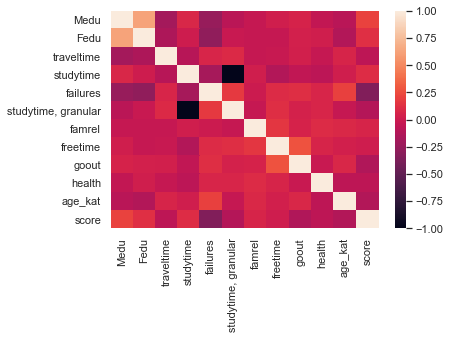

In [38]:
sns.heatmap(correlation_)

Из порядковых категорийных переменных для модели оставим все признаки

***Итак, посмотрим какие признаки у нас попадают в данные для построения модели:***

In [39]:
stud_math.head()

,sex,age,address,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,paid,higher,internet,romantic,famrel,freetime,goout,health,score,age_kat
0,F,18,U,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,yes,NaN,no,4.0,3.0,4.0,3.0,30.0,2
1,F,17,U,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,no,yes,yes,no,5.0,3.0,3.0,3.0,30.0,1
2,F,15,U,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,NaN,yes,yes,NaN,4.0,3.0,2.0,3.0,50.0,1
3,F,15,U,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,3.0,2.0,2.0,5.0,75.0,1
4,F,16,U,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,no,4.0,3.0,2.0,5.0,50.0,1


In [40]:
display(stud_math.describe())
stud_math.describe(include='object')

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,score,age_kat
count,387.000000,384.000000,363.000000,359.000000,380.000000,365.000000,361.000000,377.000000,379.000000,372.000000,381.000000,387.000000
mean,16.677003,2.752604,2.512397,1.442897,2.042105,0.328767,3.950139,3.244032,3.118734,3.526882,52.296588,1.286822
std,1.263913,1.104817,1.095816,0.698321,0.846109,0.738554,0.889916,0.983304,1.112289,1.397660,23.065438,0.475195
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,40.000000,1.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,55.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,70.000000,2.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,100.000000,3.000000


,sex,address,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,paid,higher,internet,romantic
count,387,370,345,368,351,370,357,378,347,367,353,356
unique,2,2,2,5,5,4,3,2,2,2,2,2
top,F,U,T,other,other,course,mother,no,no,yes,yes,no
freq,202,289,311,129,195,136,245,329,196,349,298,236


In [41]:
for col in stud_math.columns:
    pct_missing = stud_math[col].isna().mean()
    print(f'{col} - {pct_missing :.2%}')

sex - 0.00%
age - 0.00%
address - 4.39%
Pstatus - 10.85%
Medu - 0.78%
Fedu - 6.20%
Mjob - 4.91%
Fjob - 9.30%
reason - 4.39%
guardian - 7.75%
traveltime - 7.24%
studytime - 1.81%
failures - 5.68%
schoolsup - 2.33%
paid - 10.34%
higher - 5.17%
internet - 8.79%
romantic - 8.01%
famrel - 6.72%
freetime - 2.58%
goout - 2.07%
health - 3.88%
score - 1.55%
age_kat - 0.00%


В полученных данных оставлено 387 строк для анализа, но не заполнены пропущенные значения. Процент пропусков в данных не превышает 10.34%, поэтому пока на данный момент можем эти данные оставить в таком виде:

In [42]:
stud_model = stud_math

Давайте для модели возьмем еще альтернативные данные, которые возьмем из stud_model, но заполним все пропуски.
В столбцах с числовыми признаками пропущенные данные заполним медианным значением, а в столбцах с нечисловыми данными - значением моды.

In [43]:
stud_model_alt = stud_model.copy()

In [44]:
column = stud_model_alt.columns
for col in column:
    if col in stud_model_alt.select_dtypes(include=[np.number]):
        stud_model_alt[col].fillna(stud_model_alt[col].median(), inplace=True)
    else:
        stud_model_alt[col].fillna(stud_model_alt[col].mode()[0], inplace=True)

In [45]:
display(stud_model_alt.describe())
stud_model_alt.describe(include='object')

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,score,age_kat
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,16.677003,2.754522,2.480620,1.410853,2.041344,0.310078,3.953488,3.237726,3.116279,3.545220,52.338501,1.286822
std,1.263913,1.100729,1.068393,0.682259,0.838421,0.721237,0.859514,0.971257,1.100833,1.373282,22.887914,0.475195
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,42.500000,1.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,55.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,4.500000,4.000000,4.000000,5.000000,70.000000,2.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,100.000000,3.000000


,sex,address,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,paid,higher,internet,romantic
count,387,387,387,387,387,387,387,387,387,387,387,387
unique,2,2,2,5,5,4,3,2,2,2,2,2
top,F,U,T,other,other,course,mother,no,no,yes,yes,no
freq,202,306,353,148,231,153,275,338,236,369,332,267


### Выводы

Итак в результате EDA для анализа влияния условий жизни учащихся на оценку по госэкзамену по математике были получены следующие выводы:  
1. Во всех данных, кроме данных в столбцах shool, sex, age, есть пропущенные значения. Их количество колеблется от 0.76 % до 10.85 %, в принципе процент пропусков некритичный. 
2. Выбросы найдены в 3-х признаках: Fedu, famrel и absences. Это скорее всего обусловлено некорректным сбором или вводом информации особенно по признаку absences, т.к. у него имеются критические выбросы в значениях (больше 200) и много значений, превышающих предполагаемый диапазон значений до 20.    
3. Так как имеем допустимый процент пропусков в значениях в пределах 10%, то для построения модели попробуем взять 2 варианта данных: данные с незаполненными пропусками и данные, в которых пропуски были заполнены для числовых признаков медианным значением, а для категорийных признаков - значением моды. 
4. Из 29 признаков 7 признаков по проведенному анализу не оказывают сильного влияния на итоговую оценку по математике. Как ни странно, этими признаками оказались количество пропущенных занятий учениками и семейная образовательная поддержка. 
5. Самые важные параметры, которые предполагаются использовать в дальнейшем для построения модели, это sex, age, address, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, paid, higher, internet, romantic, famrel, freetime, goout, health, score, age_kat.

Комментарий для ментора: в этом варианте решения оставила возможно много признаков для модели, так как еще не совсем понятно какие могут быть полезны, а какие не очень. Такое понимание только с опытом приходит. Статистический анализ в проекте взят из модуля, и с его помощью как-то маловато определилось признаков, влияющих на целевую переменную.